<a href="https://colab.research.google.com/github/Itisbeen/Data_Analysis_project/blob/main/DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# import pandas as pd
# import numpy as np

# bit_url = 'https://raw.githubusercontent.com/Itisbeen/Data_Analysis_project/refs/heads/main/csv_file/BTC_USD%20%EA%B3%BC%EA%B1%B0%20%EB%8D%B0%EC%9D%B4%ED%84%B0.csv'
# nasdaq_url = 'https://raw.githubusercontent.com/Itisbeen/Data_Analysis_project/refs/heads/main/csv_file/%EB%82%98%EC%8A%A4%EB%8B%A5%20100%20%EA%B3%BC%EA%B1%B0%20%EB%8D%B0%EC%9D%B4%ED%84%B0.csv'
# oil_url = 'https://raw.githubusercontent.com/Itisbeen/Data_Analysis_project/refs/heads/main/csv_file/WTI%EC%9C%A0%20%EC%84%A0%EB%AC%BC%20%EA%B3%BC%EA%B1%B0%20%EB%8D%B0%EC%9D%B4%ED%84%B0.csv'
# gold_url = 'https://raw.githubusercontent.com/Itisbeen/Data_Analysis_project/refs/heads/main/csv_file/%EA%B8%88%20%EC%84%A0%EB%AC%BC%20%EA%B3%BC%EA%B1%B0%20%EB%8D%B0%EC%9D%B4%ED%84%B0.csv'


# df_bitcoin = pd.read_csv(bit_url)
# df_nasdaq = pd.read_csv(nasdaq_url)
# df_gold = pd.read_csv(gold_url)
# df_oil = pd.read_csv(oil_url)

# investing 을 이용한 csv 직접 다운 형식 -> 사용하지 않을 예정

In [23]:
!pip install yfinance --upgrade # 코드 실행전 yfinance 오류를 막기 위한 업데이트

In [24]:
import yfinance as yf
import pandas as pd

# 데이터 가져오기 (예시 기간)
start_date = "2022-01-01"
end_date = "2023-01-01"

tickers = {
    "BTC-USD": "UTC",  # 비트코인은 UTC로 가정 또는 yfinance가 제공하는대로
    "^IXIC": "America/New_York", # NASDAQ
    "GC=F": "America/New_York"  # 금 선물 (거래소에 따라 다를 수 있으나, Yahoo Finance는 보통 ET로 제공)
}

all_closes = []

for ticker_symbol, exchange_tz in tickers.items():
    data = yf.Ticker(ticker_symbol).history(start=start_date, end=end_date, interval="1d")

    if data.empty:
        print(f"데이터 없음: {ticker_symbol}")
        continue

    # 1. yfinance가 이미 시간대 정보를 포함하고 있는지 확인
    if data.index.tz is None:
        # 시간대 정보가 없다면 명시적으로 로컬라이즈 (BTC의 경우 UTC로 가정)
        data.index = data.index.tz_localize(exchange_tz if exchange_tz else 'UTC')

    # 2. 모든 데이터를 UTC로 변환
    data.index = data.index.tz_convert('UTC')

    # 3. 상관관계 분석을 위해 날짜 기준으로 정규화 (시간 정보 제거)
    #    이렇게 하면 UTC 기준 '2023-01-03'의 NASDAQ 종가(21:00 UTC경)와
    #    UTC 기준 '2023-01-03'의 BTC 종가(23:59 UTC경)를 비교하게 됨.
    data.index = data.index.normalize() # 시간을 00:00:00 UTC로 설정, 날짜는 유지

    # 종가만 선택하고 컬럼 이름 변경
    close_prices = data[['Close']].rename(columns={'Close': ticker_symbol})
    all_closes.append(close_prices)

# 4. 모든 종가 데이터를 병합
if not all_closes:
    print("처리할 데이터가 없습니다.")
else:
    combined_df = pd.concat(all_closes, axis=1)

    # 5. NaN 값 처리 (주말, 공휴일 등으로 인한 비거래일 데이터)
    #    방법 1: NaN이 하나라도 있는 행 전체 제거
    # combined_df_cleaned = combined_df.dropna()
    #    방법 2: 앞선 값으로 채우고, 그래도 남은 NaN(시작 부분) 제거 (데이터 특성에 따라 선택)
    combined_df_cleaned = combined_df.fillna(method='ffill').dropna()


    if combined_df_cleaned.empty:
        print("데이터 병합 및 정제 후 남은 데이터가 없습니다.")
    else:
        print("정제된 데이터 (처음 5행):")
        print(combined_df_cleaned.head())

        # 6. 상관관계 계산
        correlation_matrix = combined_df_cleaned.corr()
        print("\n상관관계 행렬:")
        print(correlation_matrix)

정제된 데이터 (처음 5행):
                                BTC-USD         ^IXIC         GC=F
Date                                                              
2022-01-03 00:00:00+00:00  46458.117188  15832.799805  1799.400024
2022-01-04 00:00:00+00:00  45897.574219  15622.719727  1814.000000
2022-01-05 00:00:00+00:00  43569.003906  15100.169922  1824.599976
2022-01-06 00:00:00+00:00  43160.929688  15080.860352  1788.699951
2022-01-07 00:00:00+00:00  41557.902344  14935.900391  1797.000000

상관관계 행렬:
          BTC-USD     ^IXIC      GC=F
BTC-USD  1.000000  0.890907  0.753562
^IXIC    0.890907  1.000000  0.601590
GC=F     0.753562  0.601590  1.000000


<ipython-input-24-1f5f6fcf9d97>:50: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df_cleaned = combined_df.fillna(method='ffill').dropna()


In [25]:
# 짬통 코드
# btc_data.to_csv('btc_data.csv')
# gold_data.to_csv('gold_data.csv')
# oil_data.to_csv('oil_data.csv')
# nasdaq_data.to_csv('nasdaq_data.csv')

In [26]:
import yfinance as yf # yahoo finance module 을 사용한 방식

tickers = ['BTC-USD', 'GC=F', 'CL=F', '^IXIC'] # ['비트코인', '금', '원유', '나스닥']
# https://finance.yahoo.com/quote/BTC-USD/
data = yf.download(  # 기본적으로 yfinance 는 pandas dataframe 으로 반환
    tickers,
    start='2014-09-17', # yahoo finance 의 btc historical data 는 14년부터 존재
    end='2025-05-04',
    interval='1d',       # 일간
    auto_adjust=True,    # 배당/스플릿 보정
    actions=False,
    group_by='ticker'    # ticker 밑에 가격 생성
)

data['BTC-USD'].tail() # 자산 밑에 시가, 고가, 저가, 종가, 거래량 순

[*********************100%***********************]  4 of 4 completed


Price,Open,High,Low,Close,Volume
Date,,,,,
2025-04-29,94981.859375,95485.414062,93796.632812,94284.789062,25806129921
2025-04-30,94286.468750,95249.320312,92979.640625,94207.312500,28344679831
2025-05-01,94212.859375,97437.960938,94153.632812,96492.335938,32875889623
2025-05-02,96494.968750,97905.898438,96375.945312,96910.070312,26421924677
2025-05-03,96904.632812,96943.882812,95821.289062,95891.796875,15775154889


In [27]:
gold_data = data['GC=F']
oil_data = data['CL=F']
nasdaq_data = data['^IXIC']
btc_data = data['BTC-USD']

print(gold_data.shape)
print(oil_data.shape)
print(nasdaq_data.shape)
print(btc_data.shape)

(3882, 5)
(3882, 5)
(3882, 5)
(3882, 5)


In [28]:
print(btc_data.index[0], oil_data.index[0], gold_data.index[0], nasdaq_data.index[0]) # UTC 00:00 기준 데이터
print(btc_data.index[-1], oil_data.index[-1], gold_data.index[-1], nasdaq_data.index[-1]) # UTC 00:00 기준 데이터

2014-09-17 00:00:00 2014-09-17 00:00:00 2014-09-17 00:00:00 2014-09-17 00:00:00
2025-05-03 00:00:00 2025-05-03 00:00:00 2025-05-03 00:00:00 2025-05-03 00:00:00


In [29]:
print(btc_data['Close'].isna().sum()) # 24시간 거래이므로 결측치가 없음
print(gold_data['Close'].isna().sum()) # 주말 및 공휴일의 결측치가 존재
print(oil_data['Close'].isna().sum()) # 주말 및 공휴일의 결측치가 존재
print(nasdaq_data['Close'].isna().sum()) # 주말 및 공휴일의 결측치가 존재

0
1211
1210
1209


In [30]:
import pandas as pd
import numpy as np

# 자산 내부 Close columns 만 loc
close_data = data.loc[:, (slice(None), 'Close')]
# 컬럼을 단순화 (티커 이름만 컬럼으로 사용)
close_data.columns = close_data.columns.get_level_values(0)

close_data.shape
close_data.tail()

Ticker,CL=F,BTC-USD,GC=F,^IXIC
Date,,,,
2025-04-29,60.419998,94284.789062,3318.800049,17461.320312
2025-04-30,58.209999,94207.312500,3305.000000,17446.339844
2025-05-01,59.240002,96492.335938,3210.000000,17710.740234
2025-05-02,58.290001,96910.070312,3231.899902,17977.730469
2025-05-03,NaN,95891.796875,NaN,NaN


In [31]:
close_data = close_data.dropna(how = 'any') # row 에 nan 이 하나라도 있으면 제거

In [32]:
close_data.shape # 2670 개의 데이터

(2670, 4)

In [33]:
btc_data = close_data['BTC-USD']
oil_data = close_data['CL=F']
gold_data = close_data['GC=F']
nasdaq_data = close_data['^IXIC']

In [34]:
print(btc_data.shape)
print(oil_data.shape)
print(gold_data.shape)
print(nasdaq_data.shape)

(2670,)
(2670,)
(2670,)
(2670,)


In [35]:
from scipy.stats import shapiro # 정규성 검정을 위한 shaprio module

btc_shapiro_test = shapiro(btc_data) # p-value < 0.05 -> 매우 작은 수 : 정규성을 띄지 않음 -> Pearson 사용불가
oil_shapiro_test = shapiro(oil_data) # 피어슨 상관계수는 이론적으로 두 변수 모두 정규분포를 따라야함
gold_shapiro_test = shapiro(gold_data)
nasdaq_shapiro_test = shapiro(nasdaq_data)

# shapiro test 의 경우 데이터가 5000 개 이하여야함

print(btc_shapiro_test)
print(oil_shapiro_test) # p-value < 0.05
print(gold_shapiro_test) # p-value < 0.05
print(nasdaq_shapiro_test) # p-value < 0.05

ShapiroResult(statistic=np.float64(0.8138119299634807), pvalue=np.float64(3.0887970894164657e-48))
ShapiroResult(statistic=np.float64(0.9860518334168482), pvalue=np.float64(1.5626361240874972e-15))
ShapiroResult(statistic=np.float64(0.882888906805781), pvalue=np.float64(5.572198992236439e-41))
ShapiroResult(statistic=np.float64(0.9223522720793953), pvalue=np.float64(4.621969217595611e-35))


In [36]:
# from scipy.stats import spearmanr # spearman 상관계수 사용

# gold_corr, gold_p = spearmanr(btc_data, gold_data)
# oil_corr, oil_p = spearmanr(btc_data, oil_data)
# nasdaq_corr, nasdaq_p = spearmanr(btc_data, nasdaq_data)

# # 결과 표 만들기
# corr_table = pd.DataFrame({
#     'Asset': ['Gold', 'Oil', 'Nasdaq'],
#     'Spearman Correlation': [gold_corr, oil_corr, nasdaq_corr],
#     'P-value': [gold_p, oil_p, nasdaq_p]
# })

# # 보기 좋게 출력
# print(corr_table.to_string(index=False, float_format='%.4g'))
# 스피어맨 상관계수는 순위기반 즉, 추세가 있다면 높게 나올 확률이 높음

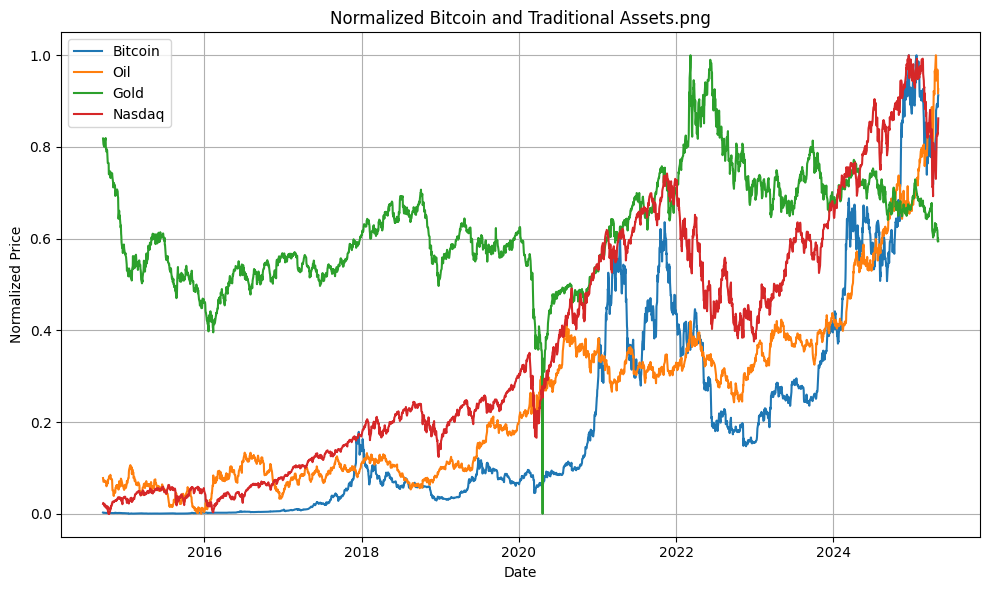

In [55]:
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Bitcoin': btc_data,
    'Gold': gold_data,
    'Oil' : oil_data,
    'Nasdaq' : nasdaq_data
})

# Min-Max 정규화
df_norm = (df - df.min()) / (df.max() - df.min())

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(df_norm.index, df_norm['Bitcoin'], label='Bitcoin')
plt.plot(df_norm.index, df_norm['Gold'], label='Oil')
plt.plot(df_norm.index, df_norm['Oil'], label='Gold')
plt.plot(df_norm.index, df_norm['Nasdaq'], label='Nasdaq')
plt.title('Normalized Bitcoin and Traditional Assets.png')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Normalized Bitcoin and Traditional Assets.png', dpi = 1000) # 파일 저장
plt.show()

# 결과 해석 : 정상성(Stationarity) 를 띄지 않고 추세를 가지고 있음
# 한 그래프에서 보기 위해 정규화를 사용함

In [56]:
btc_data_log = np.log(btc_data) # 데이터를 로그변환
gold_data_log = np.log(gold_data)
oil_data_log = np.log(oil_data)
nasdaq_data_log = np.log(nasdaq_data)

print(btc_data_log.shape)
print(gold_data_log.shape)
print(oil_data_log.shape)
print(nasdaq_data_log.shape)
btc_data_log.head()

(2670,)
(2670,)
(2670,)
(2670,)


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,BTC-USD
Date,
2014-09-17,6.125414
2014-09-18,6.050771
2014-09-19,5.978369
2014-09-22,5.996830
2014-09-23,6.077163


In [57]:
btc_data_log_diff = btc_data_log.diff() # 차분 ln(P) = ln(P) - ln(P-1)
gold_data_log_diff = gold_data_log.diff()
oil_data_log_diff = oil_data_log.diff()
nasdaq_data_log_diff = nasdaq_data_log.diff()

print(btc_data_log_diff.shape)
print(gold_data_log_diff.shape)
print(oil_data_log_diff.shape)
print(nasdaq_data_log_diff.shape)

print(oil_data_log_diff[oil_data_log_diff.isna()]) # 20년 4월 20일 원유 가격 음수 -> log 변환 0 -> 차분 이후 nan

btc_data_log_diff.head() # 차분 이후 첫번째 값은 항상 Nan
# 코드 동작마다 nan 갯수 증가하는 것 방지 위해
# 전부 다른 변수 사용

(2670,)
(2670,)
(2670,)
(2670,)
Date
2014-09-17   NaN
2020-04-20   NaN
2020-04-21   NaN
Name: CL=F, dtype: float64


,BTC-USD
Date,
2014-09-17,NaN
2014-09-18,-0.074643
2014-09-19,-0.072402
2014-09-22,0.018461
2014-09-23,0.080333


In [58]:
df = pd.DataFrame({
    'Bitcoin': btc_data_log_diff,
    'Gold': gold_data_log_diff,
    'Oil' : oil_data_log_diff,
    'Nasdaq' : nasdaq_data_log_diff
})

df = df.dropna(how = 'any') # 하나라도 nan 이면 제거
df.shape

(2667, 4)

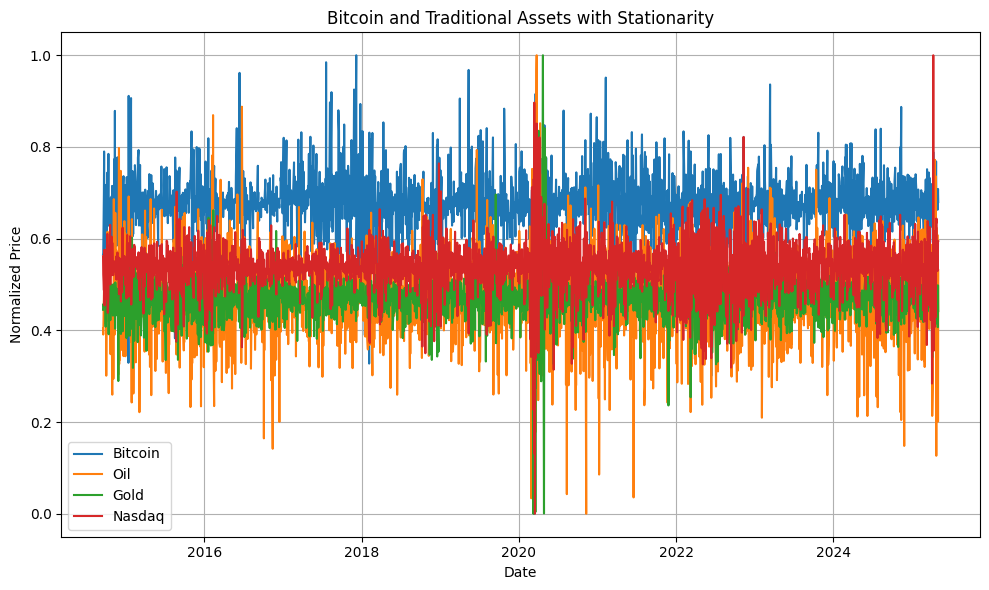

In [51]:
# Min-Max 정규화
df_norm = (df - df.min()) / (df.max() - df.min())

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(df_norm.index, df_norm['Bitcoin'], label='Bitcoin')
plt.plot(df_norm.index, df_norm['Gold'], label='Oil')
plt.plot(df_norm.index, df_norm['Oil'], label='Gold')
plt.plot(df_norm.index, df_norm['Nasdaq'], label='Nasdaq')
plt.title('Bitcoin and Traditional Assets with Stationarity')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Stationarity.png', dpi = 1000)
plt.show()
# 해석 : 로그 차분 계산을 통해 자료에서 추세가 사라지고, Stationarity 를 띄게 함

In [52]:
btc_shapiro_test = shapiro(btc_data) # p-value < 0.05 -> 매우 작은 수 : 정규성을 띄지 않음 -> Pearson 사용불가
oil_shapiro_test = shapiro(oil_data) # 피어슨 상관계수는 이론적으로 두 변수 모두 정규분포를 따라야함
gold_shapiro_test = shapiro(gold_data)
nasdaq_shapiro_test = shapiro(nasdaq_data)

# shapiro test 의 경우 데이터가 5000 개 이하여야함

print(btc_shapiro_test)
print(oil_shapiro_test) # p-value < 0.05
print(gold_shapiro_test) # p-value < 0.05
print(nasdaq_shapiro_test) # p-value < 0.05
# Stationarity 가 정규분포를 만들어주지는 않는다.

ShapiroResult(statistic=np.float64(0.8138119299634807), pvalue=np.float64(3.0887970894164657e-48))
ShapiroResult(statistic=np.float64(0.9860518334168482), pvalue=np.float64(1.5626361240874972e-15))
ShapiroResult(statistic=np.float64(0.882888906805781), pvalue=np.float64(5.572198992236439e-41))
ShapiroResult(statistic=np.float64(0.9223522720793953), pvalue=np.float64(4.621969217595611e-35))


In [53]:
from scipy.stats import pearsonr # 정규성을 띄지 않더라도 데이터가 충분히 많고 정상성을 띄기에 피어슨 상관계수 사용

gold_corr, gold_p = pearsonr(df['Bitcoin'], df['Gold'])
oil_corr, oil_p = pearsonr(df['Bitcoin'], df['Oil'])
nasdaq_corr, nasdaq_p = pearsonr(df['Bitcoin'], df['Nasdaq'])

print(f"피어슨 상관계수: {gold_corr:.4f}")
print(f"p-value: {gold_p:.4f}")
print(f"피어슨 상관계수: {oil_corr:.4f}")
print(f"p-value: {oil_p:.4f}")
print(f"피어슨 상관계수: {nasdaq_corr:.4f}")
print(f"p-value: {nasdaq_p:.4f}")
# p-value < 0.05 피어슨 상관계수가 통계적으로 유의미함
# 비트코인과 전통자산인 금, 원유, 나스닥 지수와의 상관관계는 매우 약한 정도로 확인됨


피어슨 상관계수: 0.0830
p-value: 0.0000
피어슨 상관계수: 0.0512
p-value: 0.0081
피어슨 상관계수: 0.2432
p-value: 0.0000


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49832 (\N{HANGUL SYLLABLE SEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

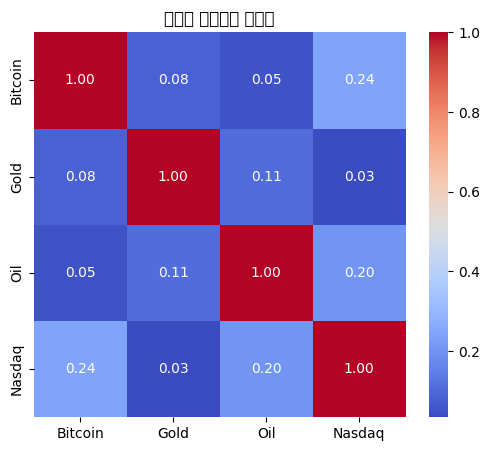

In [54]:
# 미완성부분

import seaborn as sns

# Bitcoin, Gold, Oil, Nasdaq 간의 상관관계만 추출
cols = ['Bitcoin', 'Gold', 'Oil', 'Nasdaq']
corr_matrix = df[cols].corr(method='pearson')

# 히트맵 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('피어슨 상관관계 히트맵')
plt.show()


**References**

1. 이은주. "비트코인과 주요 자산 간 상관관계 분석: 금, 주식, 달러와의 비교." 국내석사학위논문 고려대학교 정책대학원, 2025. 서울

2. Bitcoin: Medium of exchange or speculative assets?